# Régression & optimisation par descente de gradient

In [60]:
%load_ext autoreload
%autoreload 2
    
import tme8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ce tme a deux objectifs: 
 - acquérir les connaissances de base pour faire face au problème de la régression, c'est à dire de l'estimation d'un score réel correpondant à une situation,
 - travailler sur les techniques d'optimisation par descente de gradient

In [61]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0) # pour avoir les même résultats aléatoires à chaque run

## Génération de données jouet & construction d'une solution analytique

Dans un premier temps, générons des données jouets paramétriques:
 - $N$: nombre de points à générer
 - $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() -au choix-
     - Si vous optez pour un tirage aléatoire des abscisses, triez les points pour simplifier les traitements ultérieurs
 - $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
     - Rappel : en multipliant un tirage aléatoire selon une gaussienne centrée réduite par $\sigma$ on obtient le bruit décrit ci-dessus

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tirés selon la même distribution. L'ensemble de test comptera -arbitrairement- 1000 points.

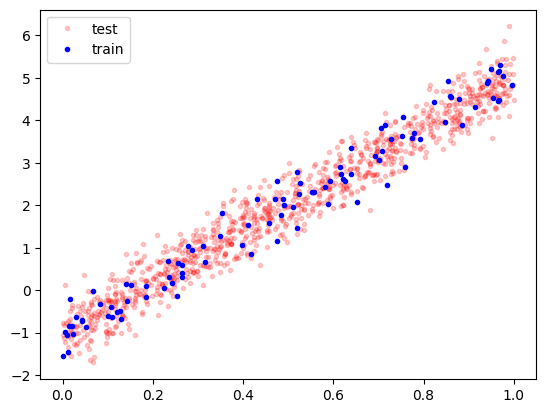

In [62]:
# génération de données jouets:
a = 6.
b = -1.
N = 100
Ntest=1000
sig = .4 # écart type

X_train, y_train, X_test, y_test = tme8.gen_data_lin(a, b, sig, N,Ntest)

plt.plot(X_test, y_test, 'r.',alpha=0.2,label="test")
plt.plot(X_train, y_train, 'b.',label="train")
plt.legend();
#plt.savefig('gen_data.png')

## Validation des formules analytiques
Nous avons vu deux types de résolutions analytique: à partir des estimateurs des espérances et co-variances d'une part et des moindres carrés d'autre part. Testons les deux méthodes.

### Estimation de paramètres probabilistes
 - $\hat a = \frac{\mbox{cov}(X,Y)}{\sigma_x^2}$
 - $\hat b = E(Y)−\frac{\mbox{cov}(X,Y)}{\sigma_x^2} E(X)$
  
**Estimer les paramètres $\hat a$ et $\hat b$ dans la fonction suivante `modele_lin_analytique`.**

*N.B. : dans les formules, il faut utiliser la covariance $\mbox{cov}(X,Y)$ empirique (non corrigée). Pour $\mbox{cov}(X,Y)$, utiliser `bias=True` dans `np.cov` (pour la variance $\sigma_x^2$, `np.var` donne la variance non corrigée).*

In [63]:
ahat, bhat = tme8.modele_lin_analytique(X_train, y_train)
print(f"{ahat=:0.4f}, {bhat=:0.4f}")

ahat=6.1126, bhat=-1.0417


Calculer le valeurs prédites par ces paramètres pour un `X` puis calculer l'erreur au sens des moindres carrés sur les données d'apprentissage et de test

In [64]:
yhat_train = tme8.calcul_prediction_lin(X_train,ahat,bhat)
yhat_test  = tme8.calcul_prediction_lin(X_test,ahat,bhat)

print(f"{tme8.erreur_mc(y_train, yhat_train)=:.4f}")
print(f"{tme8.erreur_mc(y_test, yhat_test)=:.4f}")

tme8.erreur_mc(y_train, yhat_train)=0.1289
tme8.erreur_mc(y_test, yhat_test)=0.1527


Dessiner les nuages de points et dessiner la droite de régression. 

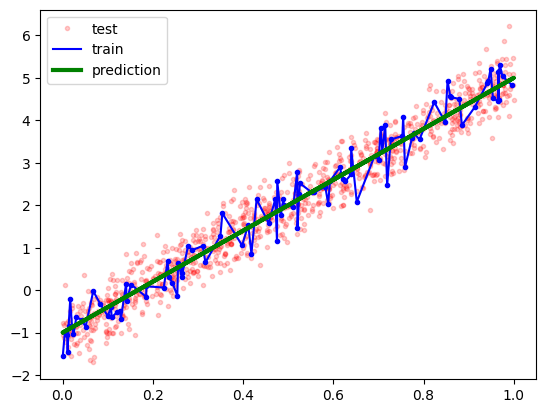

In [65]:
tme8.dessine_reg_lin(X_train, y_train, X_test, y_test,a,b)

## Formulation au sens des moindres carrés

Nous partons directement sur une écriture matricielle. Du coup, il est nécessaire de construire la matrice enrichie $Xe$:
    $$Xe = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Il faut ensuite poser et résoudre un système d'équations linéaires de la forme:
$$ A w = B $$
**Rappel des formules vues en cours/TD:**
$$ A=X^T X$$
$$ B=X^T Y$$
Fonction de résolution: `np.linalg.solve(A,B)`
Vous devez obtenir la même solution que précédemment. 

**Commencer par écrire la fonction pour générer les données enrichies $Xe$**

In [66]:
Xe = tme8.make_mat_lin_biais(X_train)
print(f"{Xe[:10]}")

[[6.64218590e-04 1.00000000e+00]
 [5.31004761e-03 1.00000000e+00]
 [1.00636957e-02 1.00000000e+00]
 [1.13551285e-02 1.00000000e+00]
 [1.35087066e-02 1.00000000e+00]
 [1.70604863e-02 1.00000000e+00]
 [2.09500693e-02 1.00000000e+00]
 [2.42727046e-02 1.00000000e+00]
 [3.06610483e-02 1.00000000e+00]
 [4.29061904e-02 1.00000000e+00]]


w=array([ 5.99749259, -0.9544149 ])
tme8.erreur_mc(y_train, tme8.calcul_prediction_matriciel(Xe,w))=0.1586

Pour rappel : ahat=5.9375, bhat=-0.9257
tme8.erreur_mc(y_test, yhat_test)=0.1584


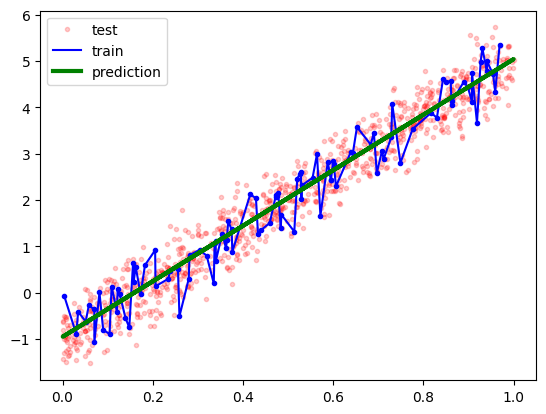

In [38]:
w = tme8.reglin_matriciel(Xe,y_train)

print(f"{w=}")

print(f"{tme8.erreur_mc(y_train, tme8.calcul_prediction_matriciel(Xe,w))=:.4f}")

print()
print(f"Pour rappel : {ahat=:0.4f}, {bhat=:0.4f}")
print(f"{tme8.erreur_mc(y_test, yhat_test)=:.4f}")

tme8.dessine_reg_lin(X_train, y_train, X_test, y_test,w[0],w[1])

## Données polynomiales

Soit les données polynomiales générées comme suit :
$$y = ax^2 + bx + c + eps$$ avec $eps \sim {\cal N}(0,sig^2)$

 - proposer & une solution d'enrichissement (vue en cours et TD) 
 - résoudre analytiquement le problème des moindres carrés
 - calculer l'erreur au sens des moindes carrés en apprentissage ET en test
 - tracer les données et la solution

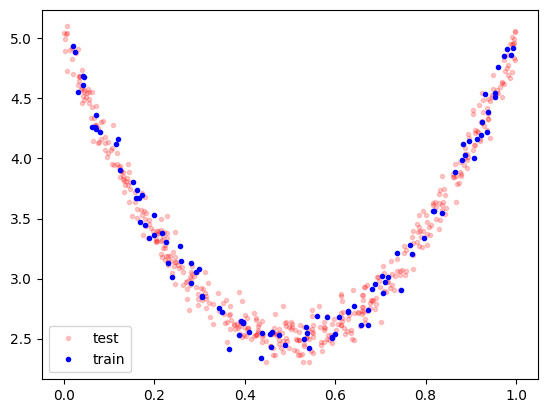

In [42]:
Xp_train, yp_train, Xp_test, yp_test = tme8.gen_data_poly2(a=10, b=-10, c=5, sig=0.1, N=100, Ntest=500)

plt.plot(Xp_test, yp_test, 'r.',alpha=0.2,label="test")
plt.plot(Xp_train, yp_train, 'b.',label="train")
plt.legend();

In [1]:
#enrichissement
Xe   = tme8.make_mat_poly_biais(Xp_train)
Xe_t = tme8.make_mat_poly_biais(Xp_test)

print(Xe[:10])

NameError: name 'tme8' is not defined

In [49]:
w = tme8.reglin_matriciel(Xe,yp_train)
print(w)

[ 10.11263491 -10.12574366   5.03417851]


Erreur moyenne au sens des moindres carrés (train): tme8.erreur_mc(yhat, yp_train)=0.009899
Erreur moyenne au sens des moindres carrés (test): tme8.erreur_mc(yhat_t, yp_test)=0.01031


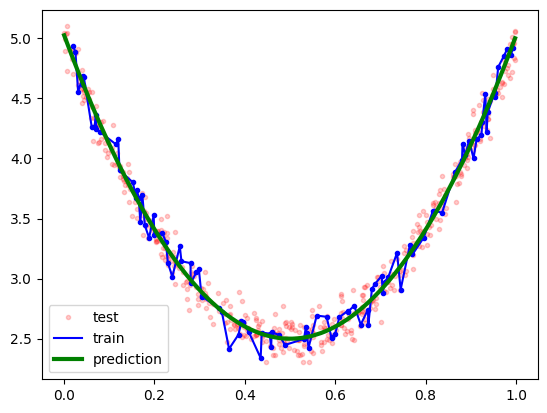

In [50]:
yhat   = tme8.calcul_prediction_matriciel(Xe,w)
yhat_t = tme8.calcul_prediction_matriciel(Xe_t,w)
print(f'Erreur moyenne au sens des moindres carrés (train): {tme8.erreur_mc(yhat, yp_train)=:.4}')
print(f'Erreur moyenne au sens des moindres carrés (test): {tme8.erreur_mc(yhat_t, yp_test)=:.4}')


tme8.dessine_poly_matriciel(Xp_train,yp_train,Xp_test,yp_test,w)

# Fonction de coût & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant résoudre le problème de la régression par minimisation d'une fonction de coût:
$$ C = \sum_{i=1}^N (y_i - f(x_i))^2$$

Soit un problème avec des données $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de décision/prédiction paramétrée par un vecteur $w$ et une fonction de cout à optimiser $C(w)$.
Notre but est de trouver les paramètres $w^\star$ minimisant la fonction de coût:
$$ w^\star = \arg\min_w C(w)$$

In [51]:
# pour travailler en matrice: (re)construction de la matrice contenant les X et un biais
Xe = tme8.make_mat_lin_biais(X_train) # dataset linéaire, transformation lineaire des données

wstar=tme8.reglin_matriciel(Xe,y_train) # pour se rappeler du w optimal
print(f"{wstar=}")

wstar=array([ 6.24150743, -1.12184332])



l'algorithme de la descente de gradient est le suivant (rappel):

 - $w_0 \leftarrow init$ par exemple : 0
 - boucle
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$
     - 
Proposer une implémentation dans `tme8.descente_grad_mc(X, y, eps=1e-4, nIterations=100)` qui rend `w,wall`: le w obtenu et l'historique des itérations.


In [52]:
w, allw = tme8.descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=500)
print(f"{w=}")
print(allw[-10:])

w=array([3.39101117, 0.51559554])
[[3.36022326 0.53328025]
 [3.3636605  0.5313059 ]
 [3.36709364 0.5293339 ]
 [3.37052268 0.52736425]
 [3.37394763 0.52539695]
 [3.37736849 0.52343199]
 [3.38078527 0.52146937]
 [3.38419797 0.51950909]
 [3.3876066  0.51755115]
 [3.39101117 0.51559554]]


On s'intéresse ensuite à comprendre la descente de gradient dans l'espace des paramètres. Le code ci-dessous permet de tracer le cout pour un ensemble de paramètres (toutes les valeurs de paramètres prises par l'algorithmes au fil du temps).


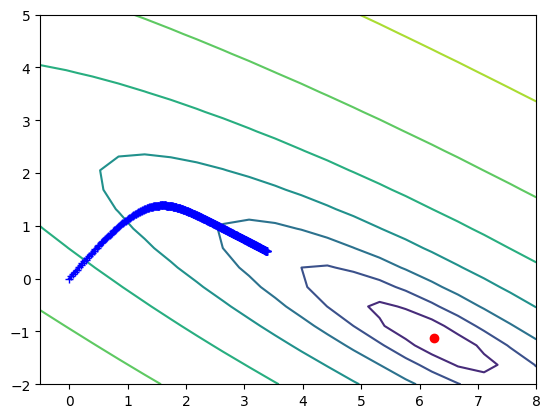

In [54]:
# tracer de l'espace des couts
def plot_parametres( allw, X, y, opti = [], ngrid = 20, extract_bornes=False):
    '''
    Fonction de tracer d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (évidemment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les données (X,y) pour calculer le cout associé 
    à un jeu de paramètres w
    ATTENTION X = forme matricielle des données
    '''
    w_min = [-0.5, -2] # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes générales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    #
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    #
    plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1],c='r')
    plt.plot(allw[:,0],allw[:,1],'b+-' ,lw=2 )
    return
    
plot_parametres( allw, Xe, y_train, opti=wstar)
# plt.savefig('fig/grad_descente.png')

Tester différents jeux de paramètres pour mettre en évidence les phénomènes suivants:
 - Divergence du gradient
 - Convergence incomplète (trop lente ou pas assez d'itération)
 - Convergence idéale: pas de gradient suffisamment grand et nombre d'itérations bien choisi

# Passage sur des données réelles

Après avoir étudié trois manières de faire face au problème de la régression, nous proposons d'étudier un cas réel: la prédiction de la consommation des voitures en fonction de leurs caractéristiques.

Dans le cas présent, nous allons baser la solution sur la résolution analytique du problème des moindres carrés (`np.linalg.solve(A,B)`), qui semble la mieux adaptée au problème qui nous intéresse.

Le jeu de données est issu des datasets UCI, un répertoire parmi les plus connus en machine learning. Les données **sont déjà téléchargées et présentes dans le tme** mais vous voulez plus d'informations:
https://archive.ics.uci.edu/ml/datasets/auto+mpg

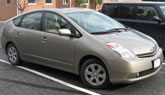

Après avoir importé les données (fonction fournie), vous construirez une solution optimale et l'évaluerez au sens des moindres carrés en apprentissage et en test.


In [55]:
import pandas as pd
# Chargement des données
data = pd.read_csv('res/auto-mpg.data', delimiter='\s+', header=None) # comme np.loadtxt mais en plus robuste
# remplacement des données manquantes '?' => Nan pour travailler sur des nombres
data.iloc[:,[3]] = data.iloc[:,[3]].replace('?', None)
data.iloc[:,[3]] = data.iloc[:,[3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data.iloc[:,[3]] = data.iloc[:,[3]].fillna(data.iloc[:,[3]].mean())

print(data.head()) # visualiser ce qu'il y a dans les données

X = np.array(data.values[:,1:-2], dtype=np.float64)
y = np.array(data.values[:,0], dtype=np.float64)


      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [56]:
# separartion app/test
def separation_train_test(X, y, pc_train=0.75):
    index = np.arange(len(y))
    np.random.shuffle(index) # liste mélangée
    napp = int(len(y)*pc_train)
    X_train, y_train = X[index[:napp]], y[index[:napp]]
    X_test, y_test   = X[index[napp:]], y[index[napp:]]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

In [57]:
# utiliser les fonctions déjà définies au maximum =
w,yhat,yhat_t=tme8.application_reelle(X_train,y_train,X_test,y_test)


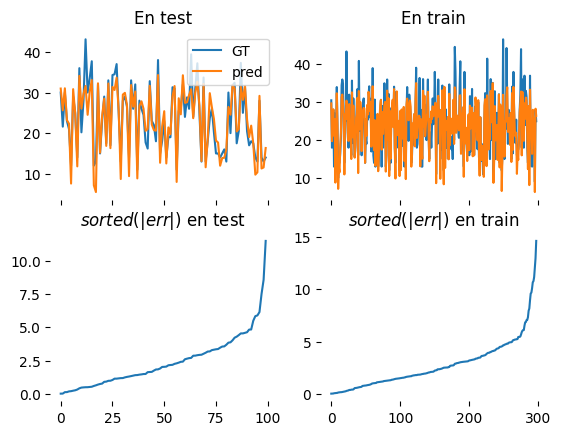

In [58]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # tracé des prédictions:
    fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=2, sharex='col', subplot_kw=dict(frameon=False)) 
    
    ax1[0].set_title('En test')
    ax1[0].plot(y_test, label="GT")
    ax1[0].plot(yhat_t, label="pred")
    ax1[0].legend()
    
    ax1[1].set_title('En train')
    ax1[1].plot(y_train, label="GT")
    ax1[1].plot(yhat, label="pred")
    
    ax2[0].set_title('$sorted(|err|)$ en test')
    ax2[0].plot(sorted(abs(y_test-yhat_t)), label="diff")
    
    ax2[1].set_title('$sorted(|err|)$ en train')
    ax2[1].plot(sorted(abs(y_train-yhat)), label="diff")
    return
plot_y(y_train, y_test, yhat, yhat_t)

<BarContainer object of 6 artists>

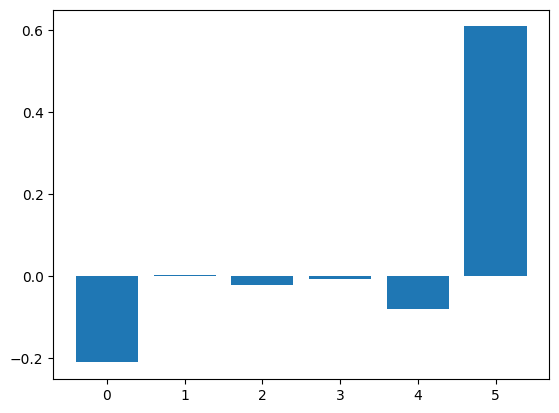

In [60]:
# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison évidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont différents.

Nous allons donc assimiler chaque colonne $X_j$ à une variable suivant une loi normale et nous allons revenir à une Normale centrée réduite selon la formule de base:

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Rightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les résultats.

**ATTENTION:** on ne se basera que sur les données d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectuée, analyser l'impact des différentes variables descriptives sur la valeur à prédire.

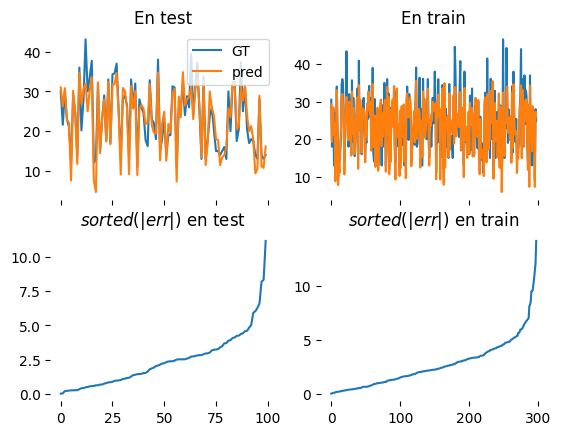

In [61]:
Xn_train, Xn_test = tme8.normalisation(X_train, X_test)
w,ynhat,ynhat_t=tme8.application_reelle(Xn_train,y_train,Xn_test,y_test)
plot_y(y_train, y_test, ynhat, ynhat_t)

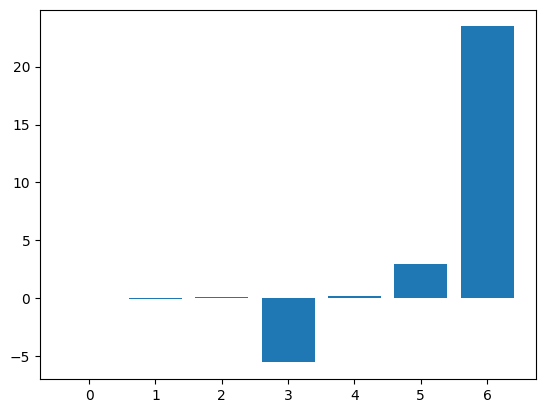

In [62]:
plt.figure()
plt.bar(np.arange(len(w)), w);

# Questions d'ouverture

## Sélection de caractéristiques

Quels sont les résultats obtenus en éliminant toutes les variables servent moins?

## Feature engineering

En étudiant la signification des variables du problèmes, on trouve:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 

D'après la question précédente, le poids, l'année du modèle et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui était difficile à coder.

### Encodage de l'origine

La variable origine est accessible de la manière suivante:

```
  origine = data.values[:,-2]
```
Il faut le faire au début du traitement pour bien conserver la séparation en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient être traités différemment en one-hot encoding:
$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.

### Encodage de l'année

Pour l'année, il est possible de procéder de la même manière, mais il préférable de découper les années en 10 catégories puis d'encoder pour limiter le nombre de dimensions.

# Question d'ouverture sur le gradient

## La normalisation a-t-elle un impact sur le gradient?

La normalisation des données peut au moins nous aider à régler plus facilement le pas (qui sera toujours du même ordre de grandeur... Mais cela a-t-il un impact sur la manière dont nous nous rapprochons de la solution optimale?

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation liés aux réseaux de neurones, le gradient est calculé de manière stochastique, sur un exemple à la fois:

- $w_0 \leftarrow init$ par exemple : 0
- boucle
     - tirage d'une donnée $i$: $(x_i,y_i)$
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$


Etudier le fonctionnement de cet algorithme sur les exemples jouets précédents.

## Amélioration du gradient

Le blog de S. Ruder explique particulièrement bien les améliorations possibles sur les descentes de gradient.

https://ruder.io/optimizing-gradient-descent/

Comparer une descente de gradient stochastique avec et sans moment sur les données jouets des premières questions.